In [3]:
%pip install seaborn
%pip install folium geopandas
%pip install sklearn
%pip install xgboost
%pip install imblearn
%pip install lightgbm
%pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.
  Using cached folium-0.18.0-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached branca-0.8.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached xyzservices-2024.9.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached pyogrio-0.10.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (5.5 kB)
  Using cached pyproj-3.7.0.tar.gz (225 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      proj executable not found. Please set the PROJ_DIR variable. For more information see: https://pyproj4.github.io/pyproj/stable/installation.html
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

×

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from matplotlib import cm, colors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
from joblib import dump
import pickle
import joblib

In [4]:
raw_df = pd.read_csv("US_Accidents_March23.csv")

In [5]:
raw_df.shape

(7728394, 46)

In [6]:
raw_df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [7]:
raw_df.dtypes

ID                        object
Source                    object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Street                    object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity                     bool
Bump      

In [8]:
wa_data = raw_df[raw_df['State'] == 'WA']
wa_data.shape

(108221, 46)

In [9]:
wa_data['State'].unique()

array(['WA'], dtype=object)

### Objective: Forecast times of high accident likelihood on specific roads, tailored for different locations.
### Approach: Use Street, Start_Time, and accident-related features (like Severity, Temperature, Weather_Condition) to predict high-risk times.
### Potential Models: Classification models like Random Forests or Gradient Boosting, or even rule-based models.
### Output: Beneficial for optimizing traffic control resources and issuing warnings during high-risk times on specific roads.

In [10]:
#
# Dropping columns which are not necessary for our analysis
wa_data = wa_data.drop(columns=['ID', 'Source', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Chill(F)', 'Wind_Direction','Amenity',
                             'Bump','Crossing', 'Give_Way','Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
                             'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'])


wa_data.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,...,State,Zipcode,Country,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition
307061,3,2016-11-30 16:06:44,2016-11-30 17:21:05,47.008610,-122.907059,NaN,NaN,0.01,Very slow traffic and right lane blocked due t...,I-5 N,...,WA,98501,US,48.0,77.0,30.09,10.0,9.2,NaN,Scattered Clouds
307062,3,2016-11-30 16:40:11,2016-11-30 17:25:11,47.014576,-122.905884,NaN,NaN,0.01,Accident on I-5 Northbound at Exit 103 Deschut...,I-5 N,...,WA,98501,US,45.0,82.0,30.11,10.0,6.9,NaN,Scattered Clouds
307063,2,2016-11-30 16:50:57,2016-11-30 17:35:17,47.649269,-122.304649,NaN,NaN,0.01,Accident on WA-513 Montlake Blvd at Pacific St.,Montlake Blvd NE,...,WA,98195,US,48.9,77.0,30.06,10.0,6.9,0.03,Light Rain
307064,2,2016-11-30 17:03:49,2016-11-30 17:47:25,46.858688,-123.257339,NaN,NaN,0.01,Accident on US-12 at Lonborg Roy Rd.,State Route 12,...,WA,98568-9608,US,46.4,87.0,30.12,9.0,9.2,NaN,Partly Cloudy
307065,2,2016-11-30 17:05:01,2016-11-30 17:34:32,47.614941,-122.328667,NaN,NaN,0.01,Right lane blocked due to accident on Pine St ...,Minor Ave,...,WA,98101-2853,US,48.9,77.0,30.06,10.0,6.9,0.03,Light Rain


In [11]:
wa_data.shape

(108221, 22)

In [12]:
null_columns = wa_data.isnull().sum()

# Display columns with null values
null_columns_with_nulls = null_columns[null_columns > 0]
print(null_columns_with_nulls)

End_Lat              63386
End_Lng              63386
Zipcode                 35
Temperature(F)         529
Humidity(%)            731
Pressure(in)           414
Visibility(mi)         834
Wind_Speed(mph)      10127
Precipitation(in)    40141
Weather_Condition      722
dtype: int64


In [13]:
# Columns with null values to be filled with mean values
columns_to_fill = [ 'Temperature(F)', 
    'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
    'Wind_Speed(mph)', 'Precipitation(in)', 
]

# For numerical columns, fill nulls with the mean
for col in columns_to_fill:
    if wa_data[col].dtype in ['float64', 'int64']:
        wa_data[col].fillna(wa_data[col].mean(), inplace=True)
    
# Confirm nulls are filled
print(wa_data[columns_to_fill].isnull().sum())


Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Speed(mph)      0
Precipitation(in)    0
dtype: int64


/var/folders/6n/w6q7td3d1r72qclcnk1t5skc0000gn/T/ipykernel_42259/561509016.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wa_data[col].fillna(wa_data[col].mean(), inplace=True)


In [14]:
null_columns_new = wa_data.isnull().sum()
# Display columns with null values
null_columns_n = null_columns_new[null_columns_new > 0]
print(null_columns_n)

End_Lat              63386
End_Lng              63386
Zipcode                 35
Weather_Condition      722
dtype: int64


In [15]:
# Convert Start_Time to datetime, handling inconsistent formats
wa_data['Start_Time'] = pd.to_datetime(wa_data['Start_Time'], errors='coerce', format='mixed')

# Check for any rows that couldn't be converted (NaT) and handle them
if wa_data['Start_Time'].isnull().any():
    print("Warning: Some Start_Time values could not be parsed and were set to NaT.")
    wa_data = wa_data.dropna(subset=['Start_Time'])  # Optionally, drop rows with NaT in Start_Time

# Proceed with feature extraction
wa_data['Hour'] = wa_data['Start_Time'].dt.hour
wa_data['DayOfWeek'] = wa_data['Start_Time'].dt.day_name()
wa_data['DayNumberOfWeek'] = wa_data['Start_Time'].dt.dayofweek
wa_data['Month'] = wa_data['Start_Time'].dt.month
# Monday = 0,Tuesday = 1,Wednesday = 2,Thursday = 3,Friday = 4,Saturday = 5,Sunday = 6


wa_data.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,...,Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Hour,DayOfWeek,DayNumberOfWeek,Month
307061,3,2016-11-30 16:06:44,2016-11-30 17:21:05,47.008610,-122.907059,NaN,NaN,0.01,Very slow traffic and right lane blocked due t...,I-5 N,...,77.0,30.09,10.0,9.2,0.007712,Scattered Clouds,16,Wednesday,2,11
307062,3,2016-11-30 16:40:11,2016-11-30 17:25:11,47.014576,-122.905884,NaN,NaN,0.01,Accident on I-5 Northbound at Exit 103 Deschut...,I-5 N,...,82.0,30.11,10.0,6.9,0.007712,Scattered Clouds,16,Wednesday,2,11
307063,2,2016-11-30 16:50:57,2016-11-30 17:35:17,47.649269,-122.304649,NaN,NaN,0.01,Accident on WA-513 Montlake Blvd at Pacific St.,Montlake Blvd NE,...,77.0,30.06,10.0,6.9,0.030000,Light Rain,16,Wednesday,2,11
307064,2,2016-11-30 17:03:49,2016-11-30 17:47:25,46.858688,-123.257339,NaN,NaN,0.01,Accident on US-12 at Lonborg Roy Rd.,State Route 12,...,87.0,30.12,9.0,9.2,0.007712,Partly Cloudy,17,Wednesday,2,11
307065,2,2016-11-30 17:05:01,2016-11-30 17:34:32,47.614941,-122.328667,NaN,NaN,0.01,Right lane blocked due to accident on Pine St ...,Minor Ave,...,77.0,30.06,10.0,6.9,0.030000,Light Rain,17,Wednesday,2,11


In [16]:
# Define Boolean target: High risk (1) if Severity > 2, else Low risk (0)
wa_data['High_Risk'] = wa_data['Severity'].apply(lambda x: 1 if x > 2 else 0)
wa_data

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,...,Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Hour,DayOfWeek,DayNumberOfWeek,Month,High_Risk
307061,3,2016-11-30 16:06:44,2016-11-30 17:21:05,47.008610,-122.907059,NaN,NaN,0.010,Very slow traffic and right lane blocked due t...,I-5 N,...,30.09,10.0,9.2,0.007712,Scattered Clouds,16,Wednesday,2,11,1
307062,3,2016-11-30 16:40:11,2016-11-30 17:25:11,47.014576,-122.905884,NaN,NaN,0.010,Accident on I-5 Northbound at Exit 103 Deschut...,I-5 N,...,30.11,10.0,6.9,0.007712,Scattered Clouds,16,Wednesday,2,11,1
307063,2,2016-11-30 16:50:57,2016-11-30 17:35:17,47.649269,-122.304649,NaN,NaN,0.010,Accident on WA-513 Montlake Blvd at Pacific St.,Montlake Blvd NE,...,30.06,10.0,6.9,0.030000,Light Rain,16,Wednesday,2,11,0
307064,2,2016-11-30 17:03:49,2016-11-30 17:47:25,46.858688,-123.257339,NaN,NaN,0.010,Accident on US-12 at Lonborg Roy Rd.,State Route 12,...,30.12,9.0,9.2,0.007712,Partly Cloudy,17,Wednesday,2,11,0
307065,2,2016-11-30 17:05:01,2016-11-30 17:34:32,47.614941,-122.328667,NaN,NaN,0.010,Right lane blocked due to accident on Pine St ...,Minor Ave,...,30.06,10.0,6.9,0.030000,Light Rain,17,Wednesday,2,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728242,2,2019-08-23 11:06:31,2019-08-23 11:34:12,47.715348,-122.326081,47.714221,-122.326960,0.088,At before 1st Ave/Northgate Way/Exit 173 - Acc...,I-5 S,...,29.97,10.0,3.0,0.000000,Cloudy,11,Friday,4,8,0
7728260,2,2019-08-23 12:33:35,2019-08-23 13:00:14,47.541399,-122.304009,47.540539,-122.303106,0.073,At Boeing Access Rd/Exit 158 - Accident. Right...,I-5 S,...,29.96,10.0,3.0,0.000000,Cloudy,12,Friday,4,8,0
7728271,2,2019-08-23 13:54:42,2019-08-23 14:21:56,47.588410,-122.305860,47.588410,-122.305860,0.000,At Massachusetts St - Accident. Lane blocked.,Rainier Ave S,...,29.93,10.0,3.0,0.000000,Cloudy,13,Friday,4,8,0
7728316,2,2019-08-23 17:40:35,2019-08-23 21:40:35,46.235060,-123.871960,46.194740,-123.851485,2.953,At Astoria Brg/US-30/W Marine Dr - Accident.,Astoria-Megler Brg,...,29.92,10.0,12.0,0.000000,Mostly Cloudy,17,Friday,4,8,0


In [17]:
# Aggregation: Number of accidents by hour
hourly_accidents = wa_data.groupby('Hour').size()

# Aggregation: Number of accidents by day of the week
daily_accidents = wa_data.groupby('DayOfWeek').size().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

# Aggregation: Top 20 streets with the most accidents
top_streets = wa_data['Street'].value_counts().head(20)

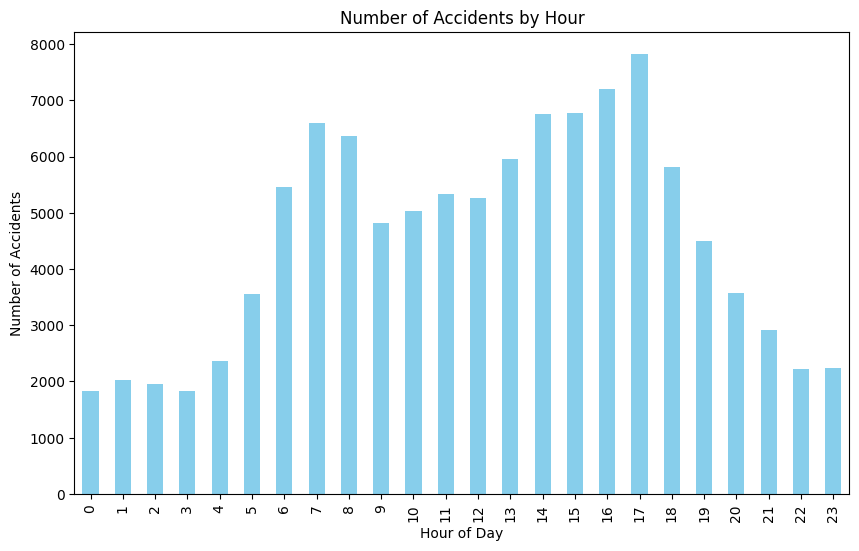

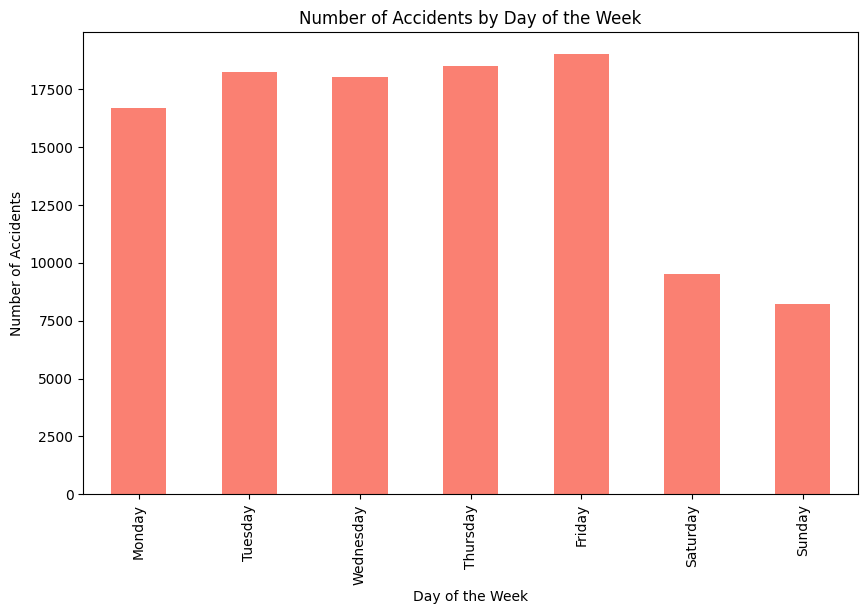

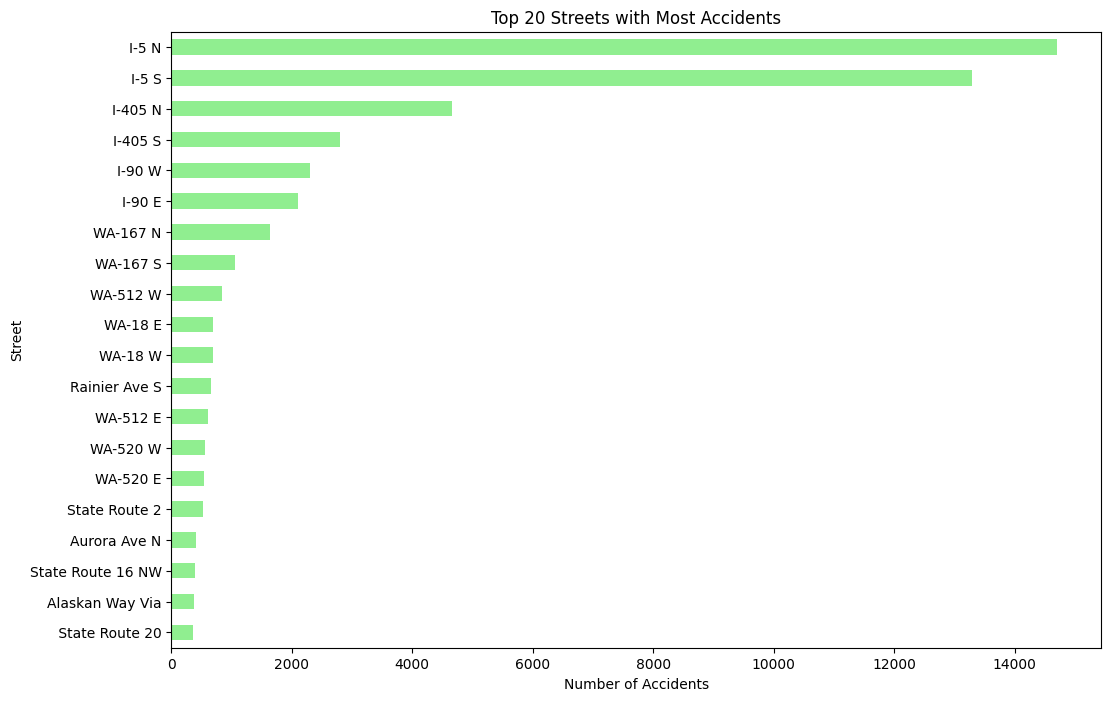

In [18]:
# Plot hourly accident distribution
plt.figure(figsize=(10, 6))
hourly_accidents.plot(kind='bar', color='skyblue')
plt.title("Number of Accidents by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.show()

# Plot daily accident distribution
plt.figure(figsize=(10, 6))
daily_accidents.plot(kind='bar', color='salmon')
plt.title("Number of Accidents by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Accidents")
plt.show()

# Plot top 20 streets with most accidents
plt.figure(figsize=(12, 8))
top_streets.plot(kind='barh', color='lightgreen')
plt.title("Top 20 Streets with Most Accidents")
plt.xlabel("Number of Accidents")
plt.ylabel("Street")
plt.gca().invert_yaxis()
plt.show()

<Axes: title={'center': 'Number of Accidents by Weather Condition'}, xlabel='Weather_Condition'>

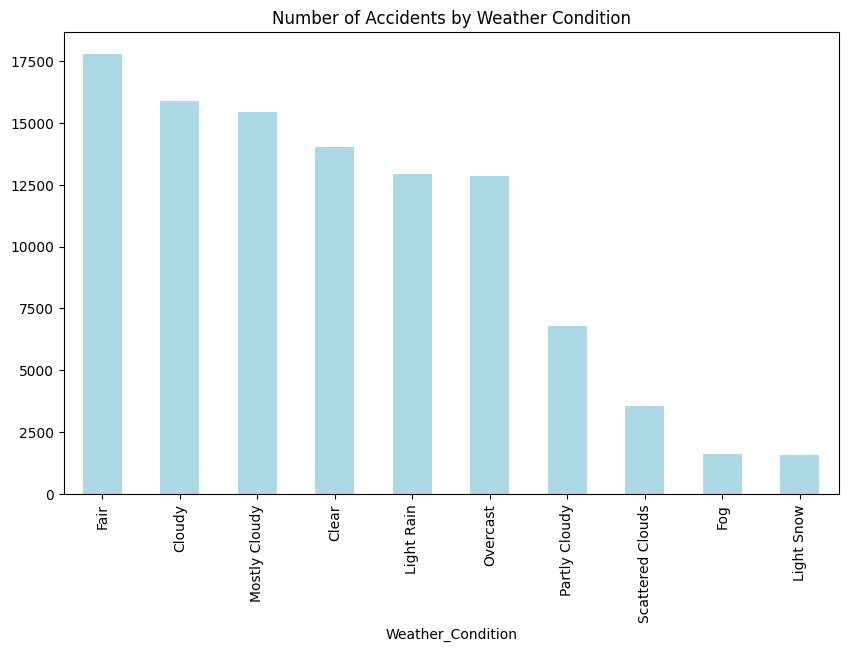

In [19]:
weather_accidents = wa_data['Weather_Condition'].value_counts().head(10)
weather_accidents.plot(kind='bar', figsize=(10, 6), color='lightblue', title="Number of Accidents by Weather Condition")


<Axes: title={'center': 'Accident Frequency by Temperature'}, ylabel='Frequency'>

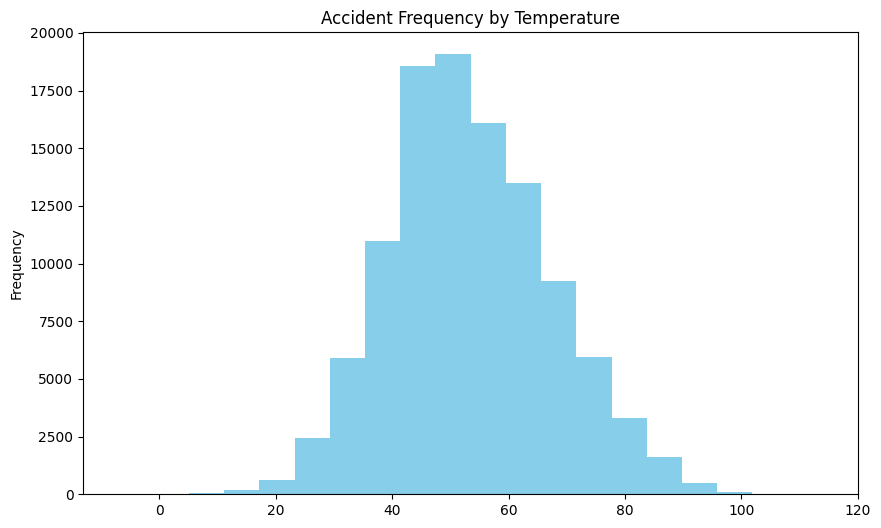

In [20]:
plt.figure(figsize=(10, 6))
wa_data['Temperature(F)'].dropna().plot(kind='hist', bins=20, color='skyblue', title="Accident Frequency by Temperature")


<Axes: title={'center': 'Number of Accidents by Month'}, xlabel='Month'>

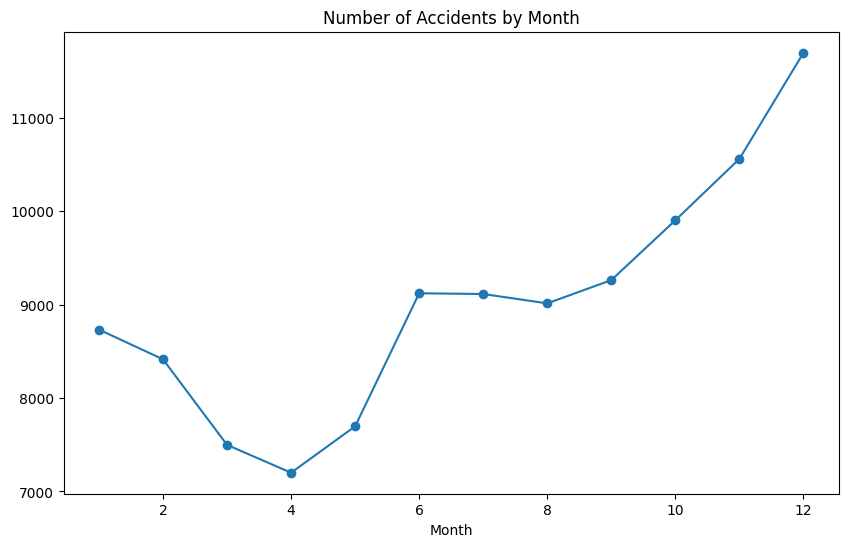

In [21]:
monthly_accidents = wa_data.groupby('Month').size()
monthly_accidents.plot(kind='line', figsize=(10, 6), marker='o', title="Number of Accidents by Month")


Text(0.5, 1.0, 'Accidents by Hour and Day of the Week')

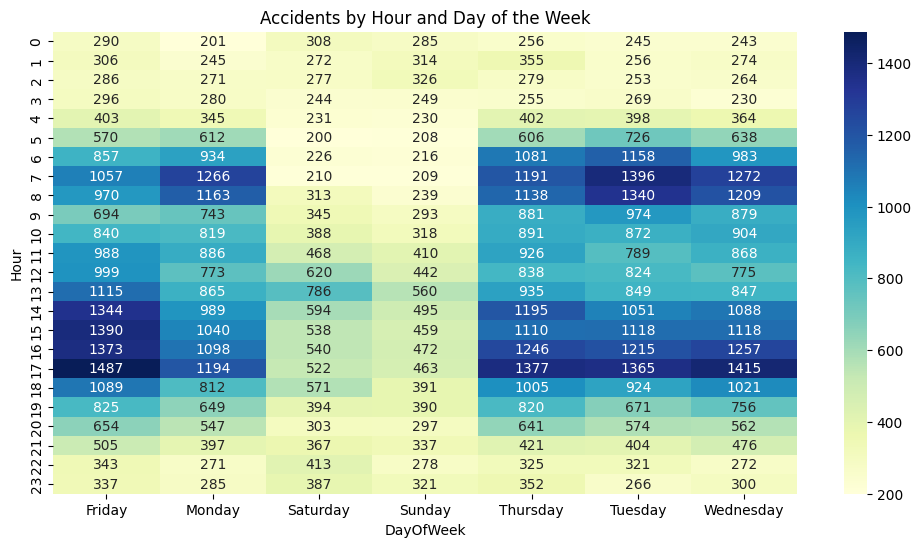

In [22]:
hour_day_accidents = wa_data.groupby(['Hour', 'DayOfWeek']).size().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(hour_day_accidents, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Accidents by Hour and Day of the Week")


In [23]:
# Group by Street to get accident counts per street
street_accidents = wa_data['Street'].value_counts().reset_index()
street_accidents.columns = ['Street', 'Accident_Count']

# Merge with the main data to get latitude and longitude for each street
street_data = wa_data[['Street', 'Start_Lat', 'Start_Lng']].drop_duplicates(subset=['Street'])
street_accidents = street_accidents.merge(street_data, on='Street', how='left')

# Normalize accident counts for color mapping
min_count, max_count = street_accidents['Accident_Count'].min(), street_accidents['Accident_Count'].max()
norm = colors.Normalize(vmin=min_count, vmax=max_count)
colormap = cm.get_cmap('YlOrRd')

# Initialize Folium map centered around Washington
wa_map = folium.Map(location=[47.5, -120.5], zoom_start=7)

# Plot each street on the map with a color based on accident count
for _, row in street_accidents.iterrows():
    accident_count = row['Accident_Count']
    # Calculate color for the marker based on normalized accident count
    color = colors.to_hex(colormap(norm(accident_count)))
    
    folium.CircleMarker(
        location=(row['Start_Lat'], row['Start_Lng']),
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=f"Street: {row['Street']}<br>Accidents: {accident_count}"
    ).add_to(wa_map)


# Save the map as an HTML file
wa_map.save("washington_accidents_map.html")


/var/folders/6n/w6q7td3d1r72qclcnk1t5skc0000gn/T/ipykernel_42259/3398058052.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('YlOrRd')


In [24]:
wa_data.dtypes

Severity                      int64
Start_Time           datetime64[ns]
End_Time                     object
Start_Lat                   float64
Start_Lng                   float64
End_Lat                     float64
End_Lng                     float64
Distance(mi)                float64
Description                  object
Street                       object
City                         object
County                       object
State                        object
Zipcode                      object
Country                      object
Temperature(F)              float64
Humidity(%)                 float64
Pressure(in)                float64
Visibility(mi)              float64
Wind_Speed(mph)             float64
Precipitation(in)           float64
Weather_Condition            object
Hour                          int32
DayOfWeek                    object
DayNumberOfWeek               int32
Month                         int32
High_Risk                     int64
dtype: object

In [66]:
# Select relevant features
features = ['Street', 'City', 'Hour', 'DayNumberOfWeek', 'Month', 'Temperature(F)', 'Weather_Condition', 'Humidity(%)', 'Visibility(mi)', 'Precipitation(in)']
X = wa_data[features]
y = wa_data['High_Risk']

In [67]:
X

,Street,City,Hour,DayNumberOfWeek,Month,Temperature(F),Weather_Condition,Humidity(%),Visibility(mi),Precipitation(in)
307061,I-5 N,Olympia,16,2,11,48.0,Scattered Clouds,77.0,10.0,0.007712
307062,I-5 N,Olympia,16,2,11,45.0,Scattered Clouds,82.0,10.0,0.007712
307063,Montlake Blvd NE,Seattle,16,2,11,48.9,Light Rain,77.0,10.0,0.030000
307064,State Route 12,Oakville,17,2,11,46.4,Partly Cloudy,87.0,9.0,0.007712
307065,Minor Ave,Seattle,17,2,11,48.9,Light Rain,77.0,10.0,0.030000
...,...,...,...,...,...,...,...,...,...,...
7728242,I-5 S,Seattle,11,4,8,65.0,Cloudy,65.0,10.0,0.000000
7728260,I-5 S,Seattle,12,4,8,69.0,Cloudy,54.0,10.0,0.000000
7728271,Rainier Ave S,Seattle,13,4,8,70.0,Cloudy,51.0,10.0,0.000000
7728316,Astoria-Megler Brg,Naselle,17,4,8,65.0,Mostly Cloudy,61.0,10.0,0.000000


In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# One-Hot Encode categorical columns
X = pd.get_dummies(X, columns=['Street', 'Weather_Condition', 'City'], drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize XGBoost with parameters for imbalanced data
xgb_model = XGBClassifier(scale_pos_weight=len(y) / sum(y), random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       0.89      0.63      0.74     22215
           1       0.51      0.83      0.63     10252

    accuracy                           0.69     32467
   macro avg       0.70      0.73      0.68     32467
weighted avg       0.77      0.69      0.70     32467

ROC-AUC Score: 0.8067667939212511


In [27]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Initialize Balanced Random Forest
brf_model = BalancedRandomForestClassifier(random_state=42)

# Train the model
brf_model.fit(X_train, y_train)

# Make predictions
y_pred = brf_model.predict(X_test)
y_pred_proba = brf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


/opt/anaconda3/envs/newenv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/envs/newenv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/envs/newenv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the f

              precision    recall  f1-score   support

           0       0.88      0.76      0.82     22215
           1       0.60      0.78      0.68     10252

    accuracy                           0.77     32467
   macro avg       0.74      0.77      0.75     32467
weighted avg       0.79      0.77      0.77     32467

ROC-AUC Score: 0.8354508167749134


In [29]:
# Initialize LightGBM with parameters for imbalanced data
lgb_model = lgb.LGBMClassifier(scale_pos_weight=len(y) / sum(y), random_state=42)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23765, number of negative: 51989
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1766
[LightGBM] [Info] Number of data points in the train set: 75754, number of used features: 689
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.313713 -> initscore=-0.782818
[LightGBM] [Info] Start training from score -0.782818
              precision    recall  f1-score   support

           0       0.89      0.62      0.73     22215
           1       0.50      0.84      0.63     10252

    accuracy                           0.69     32467
   macro avg       0.70      0.73      0.68     32467
weighted avg       0.77      0.69      0.70     32467

ROC-AUC Score: 0.8079176637108582


In [84]:
# Select relevant features
#features = ['Street', 'City', 'Hour', 'DayNumberOfWeek', 'Month', 'Temperature(F)', 'Weather_Condition', 'Humidity(%)', 'Visibility(mi)', 'Precipitation(in)']
features = ['City','Street','Hour', 'Weather_Condition', 'Visibility(mi)', 'Precipitation(in)']

X = wa_data[features]
y = wa_data['High_Risk']

In [87]:
# Preprocess categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['City', 'Street', 'Weather_Condition'])
    ],
    remainder='passthrough'
)

# Define and train the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Save the trained model
joblib.dump(model, 'high_risk_street_model_with_city.joblib')

              precision    recall  f1-score   support

           0       0.81      0.86      0.83     22215
           1       0.65      0.56      0.60     10252

    accuracy                           0.76     32467
   macro avg       0.73      0.71      0.72     32467
weighted avg       0.76      0.76      0.76     32467

ROC-AUC Score: 0.8087057424564271


['high_risk_street_model_with_city.joblib']

In [88]:
with open('road_risk_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [89]:
# Add predictions and probabilities to the test set for analysis
X_test['High_Risk_Prediction'] = y_pred
X_test['High_Risk_Probability'] = y_pred_proba


In [90]:
# Filter the test data to get only high-risk predictions
high_risk_data = X_test[X_test['High_Risk_Prediction'] == 1]

# Group by Street and Hour to get the list of high-risk areas by time
high_risk_by_hour = high_risk_data.groupby(['Street', 'Hour']).size().reset_index(name='High_Risk_Count')

# Sort by high-risk count and hour for better readability
high_risk_by_hour = high_risk_by_hour.sort_values(by=['High_Risk_Count', 'Hour'], ascending=[False, True])

# Display the top high-risk areas by time of day
print("Top high-risk areas by time of day:")
print(high_risk_by_hour.head(10))

# Generate a list of recommendations in the desired format
high_risk_recommendations = []
for _, row in high_risk_by_hour.iterrows():
    recommendation = f"Avoid {row['Street']} during {row['Hour']}:00 - it has a high risk of accidents."
    high_risk_recommendations.append(recommendation)

# Print the recommendations
for recommendation in high_risk_recommendations:
    print(recommendation)


Top high-risk areas by time of day:
     Street  Hour  High_Risk_Count
1022  I-5 S    14              143
1023  I-5 S    15              139
1025  I-5 S    17              139
990   I-5 N     6              136
995   I-5 N    11              129
992   I-5 N     8              125
1000  I-5 N    16              124
991   I-5 N     7              122
1024  I-5 S    16              122
1001  I-5 N    17              122
Avoid I-5 S during 14:00 - it has a high risk of accidents.
Avoid I-5 S during 15:00 - it has a high risk of accidents.
Avoid I-5 S during 17:00 - it has a high risk of accidents.
Avoid I-5 N during 6:00 - it has a high risk of accidents.
Avoid I-5 N during 11:00 - it has a high risk of accidents.
Avoid I-5 N during 8:00 - it has a high risk of accidents.
Avoid I-5 N during 16:00 - it has a high risk of accidents.
Avoid I-5 N during 7:00 - it has a high risk of accidents.
Avoid I-5 S during 16:00 - it has a high risk of accidents.
Avoid I-5 N during 17:00 - it has a high r

In [91]:
high_risk_data

,City,Street,Hour,Weather_Condition,Visibility(mi),Precipitation(in),High_Risk_Prediction,High_Risk_Probability
1643485,Seattle,Beacon Ave S,2,Cloudy,10.0,0.000000,1,0.640000
3532777,Redmond,148th Ave NE,12,Overcast,10.0,0.007712,1,0.580000
491184,Federal Way,WA-18 E,14,Partly Cloudy,10.0,0.007712,1,0.747250
752869,Bellevue,I-405 S,6,Cloudy,5.0,0.000000,1,0.880000
3037032,Tacoma,I-5 N,7,Overcast,10.0,0.007712,1,0.646224
...,...,...,...,...,...,...,...,...
453842,Seattle,I-90 E,16,Clear,10.0,0.007712,1,0.994167
1983949,Renton,Houser Way Byp,12,Fair,10.0,0.000000,1,1.000000
1861404,Renton,I-405 N,12,Cloudy,10.0,0.000000,1,0.739870
1943567,Lakewood,WA-512 W,14,Cloudy,10.0,0.000000,1,0.595000


In [97]:
high_risk_data['Visibility(mi)'].max()


np.float64(67.0)

In [99]:
wa_data['Precipitation(in)'].max()

np.float64(1.04)

In [93]:
high_risk_data.to_csv('high_risk_data.csv')

In [94]:

# Aggregate high-risk counts by Street, Hour, and Month
high_risk_by_time = high_risk_data.groupby(['Street', 'Hour']).size().reset_index(name='High_Risk_Count')
high_risk_by_time.sort_values('High_Risk_Count', ascending=False)

,Street,Hour,High_Risk_Count
1022,I-5 S,14,143
1025,I-5 S,17,139
1023,I-5 S,15,139
990,I-5 N,6,136
995,I-5 N,11,129
...,...,...,...
712,Birch Bay Lynden Rd,12,1
711,Birch Bay Lynden Rd,11,1
710,Bickford Ave,2,1
709,Benson Rd S,17,1
